In [ ]:
# default_exp utils.plots

# Visualizations Plots
> Common utilities for visualizing/plotting recsys data and patterns.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import torch
import networkx as nx

In [ ]:
#export
class Visual:
    def __init__(self):
        pass

In [ ]:
#export
class BasicVisual(Visual):
    def __init__(self, figsize=(10,10), show=True, save=False, pallete='viridis',
                 style='whitegrid', rot=45, label_x='label_x', label_y='label_y',
                 title='Basic Plot', nrows=1, ncols=1):
        super(BasicVisual, self).__init__()
        self.nrows = nrows
        self.ncols = ncols
        self.figsize = figsize
        self.show = show
        self.pallete = pallete
        self.style = style
        self.rot = rot
        self.label_x = label_x
        self.label_y = label_y
        self.title = title

        self._plot()

    def plot(self):
        raise NotImplementedError

    def _plot(self):
        self.fig, self.ax = plt.subplots(nrows=self.nrows, ncols=self.ncols,
                                         figsize=self.figsize)
        sns.set_palette(self.pallete)
        sns.set_style(self.style)
        plt.xticks(rotation=self.rot)
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.title)

        self.plot()

        plt.show()


## CountPlot

In [ ]:
#export
class CountPlot(BasicVisual):
    def __init__(self, data_x, data_y, add_pct=True, **kwargs):
        self.data_x = data_x
        self.data_y = data_y
        self.add_pct = add_pct
        super(CountPlot, self).__init__(**kwargs)

    def plot(self):
        sns.barplot(x=self.data_x, y=self.data_y, ax=self.ax)
        if self.add_pct:
            self.pct_patch()

    def pct_patch(self):
        tot_pct = 0
        total = np.sum(self.data_y)
        for p in self.ax.patches:
            height = p.get_height()
            self.ax.text(p.get_x()+p.get_width()/2.,
                    height + 1,
                    '{:1.2f}%'.format(height*100/total),
                    ha="center")
            tot_pct+= height*100/total

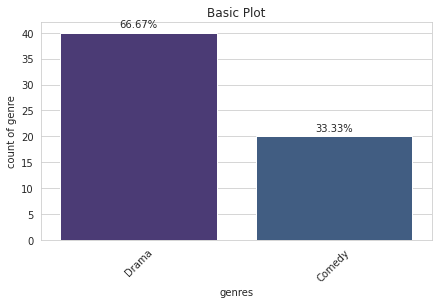

In [ ]:
df = pd.DataFrame.from_dict({
    'genres':['Drama','Comedy'],
    'count':[40,20],
})

kwargs = {'label_x':'genres', 'label_y':'count of genre', 'figsize':(7,4)}

cp = CountPlot(data_x = df.genres.values,
               data_y = df['count'].values,
               **kwargs)

cp.plot()

## LongTailPlot

In [ ]:
#export
class LongTailPlot(BasicVisual):
    def __init__(self, item_ids, user_ids, **kwargs):
        kwargs['nrows'] = 1
        kwargs['ncols'] = 2
        self.df = pd.DataFrame.from_dict({
            'user_id':user_ids,
            'item_id':item_ids,
        })
        super(LongTailPlot, self).__init__(**kwargs)

    def plot(self):
        item_rate_count = self.df.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
        self.ax[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
        self.ax[0].set_xticks([])
        self.ax[0].set(title="long tail of rating frequency", 
                    xlabel="item ordered by decreasing frequency", 
                    ylabel="#ratings")

        count = item_rate_count.value_counts()
        sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=self.ax[1])
        self.ax[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)")  

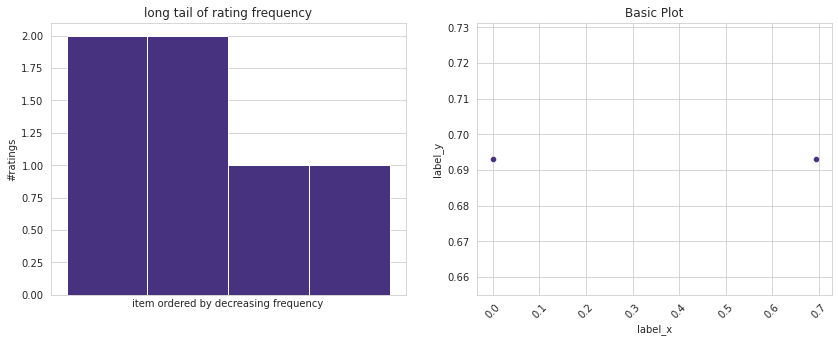

In [ ]:
df = pd.DataFrame.from_dict({
    'item_id':[1,1,2,2,2,2,3,4,4],
    'user_id':[1,2,2,2,3,3,4,4,4],
})

kwargs = {'figsize':(14,5)}

LongTailPlot(item_ids=df.item_id.values, user_ids=df.user_id.values, **kwargs)

## LongTailPlotv2

In [ ]:
#export
class LongTailPlotv2(BasicVisual):
    def __init__(self, item_ids, percentage=None, x_labels=True, **kwargs):
        """
        Plots the long tail for a user-item interaction dataset.
        ----------
        item_ids: 
            list of item ids
        percentage: float, default=None
            percent of volume to consider as the head (percent as a decimal)
            (if default=None no line will be plotted)
        x_tables bool, default=True
            if True, plot x-axis tick labels
            if False, no x-axis tick labels will be plotted.
        Returns:
        -------
            A long tail plot
        """
        self.df = pd.DataFrame.from_dict({
            'item_id':item_ids,
        })
        self.percentage = percentage
        self.x_labels = x_labels
        super(LongTailPlotv2, self).__init__(**kwargs)

    def plot(self):
        from matplotlib.lines import Line2D

        #calculate cumulative volumes
        volume_df = self.df['item_id'].value_counts().reset_index()
        volume_df.columns = ['item_id', "volume"]
        volume_df['item_id'] = volume_df['item_id'].astype(str)
        volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
        volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

        #line plot of cumulative volume
        x = range(0,len(volume_df))
        sns.lineplot(x=x, y=volume_df["volume"].values, color="black", ax=self.ax)
        plt.xticks(x)

        #set labels
        if self.percentage != None:
            #plot vertical line at the tail location
            head = volume_df[volume_df["percent_of_total_volume"] <= self.percentage]
            tail = volume_df[volume_df["percent_of_total_volume"] > self.percentage]
            items_in_head = len(head)
            items_in_tail = len(tail)
            plt.axvline(x=items_in_head, color="red",  linestyle='--')

            # fill area under plot
            head = head.append(tail.head(1))
            x1 = head.index.values
            y1 = head['volume']
            x2 = tail.index.values
            y2 = tail['volume']
            self.ax.fill_between(x1, y1, color="blue", alpha=0.2)
            self.ax.fill_between(x2, y2,  color="orange", alpha=0.2)

            #create legend
            legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                            Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
            self.ax.legend(handles=legend_elements, loc=1)

        else:
            x1 = volume_df['item_id']
            y1 = volume_df['volume']
            self.ax.fill_between(x1, y1, color="blue", alpha=0.3)
        if self.x_labels == False:
            plt.xticks([], [])
            self.ax.set(xticklabels=[])
        else:
            self.ax.set_xticklabels(labels = volume_df['item_id'], rotation = 45, ha="right")

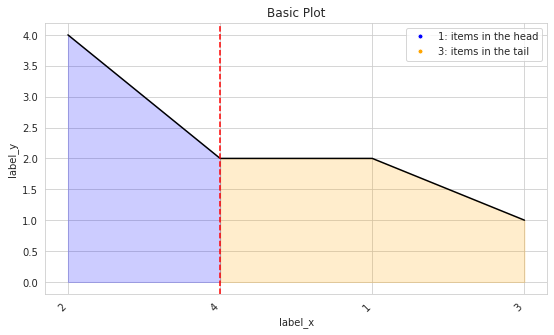

In [ ]:
item_ids = [1,1,2,2,2,2,3,4,4]

kwargs = {'figsize':(9,5)}

LongTailPlotv2(item_ids=df.item_id.values, percentage=0.5, **kwargs)

## MatrixPlot

In [ ]:
#export
class MatrixPlot(BasicVisual):
    def __init__(self, rating_matrix, interpolation=None, vmax=1, vmin=0, **kwargs):
        self.rating_matrix = rating_matrix
        self.interpolation=interpolation
        self.vmax=vmax
        self.vmin=vmin
        super(MatrixPlot, self).__init__(**kwargs)

    def plot(self):
        plt.imshow(self.rating_matrix, interpolation=self.interpolation,
                   vmax=self.vmax, vmin=self.vmin)

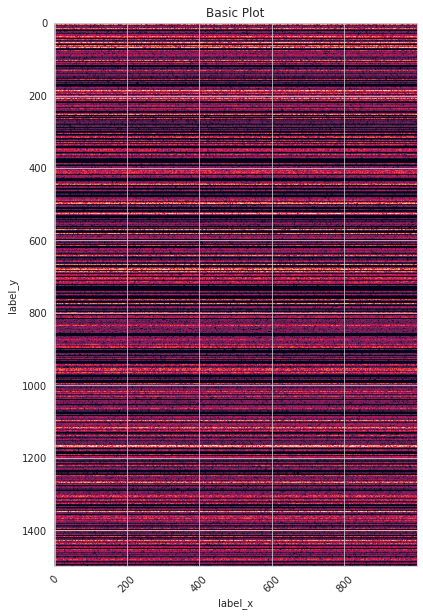

In [ ]:
rating_matrix = np.vstack((np.random.randint(0,1, size=(1000,1000)),
                             np.random.randint(0,5, size=(500,1000))))
rating_matrix_binary = rating_matrix > 0
np.random.shuffle(rating_matrix_binary)
MatrixPlot(rating_matrix_binary)

## ConfusionMatrix

In [ ]:
#export
class ConfusionMatrix(BasicVisual):
    def __init__(self, y, yhat, **kwargs):
        self.y = y
        self.yhat = yhat
        super(ConfusionMatrix, self).__init__(**kwargs)

    def plot(self):
        from itertools import product
        from sklearn.metrics import confusion_matrix

        cm = confusion_matrix(self.y, self.yhat, labels=[1,0])
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100

        fmt = ".2f"
        _ = cm.max() / 2. # TODO: Unused argument
        descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
        colors = np.array([["green", "red"], ["red", "green"]])
        plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
        for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt)+'%\n' + descriptions[i, j],
                        horizontalalignment="center",
                        color=colors[i,j])
        plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
        plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
        plt.ylabel('True')
        plt.xlabel('Predicted')
        plt.title("Confusion Matrix")
        plt.xticks([0,1], [1,0], rotation=45)
        plt.yticks([0,1], [1,0])

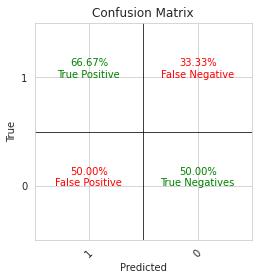

In [ ]:
kwargs = {'figsize':(5,4)}

ConfusionMatrix(y=[1,0,0,1,1], yhat=[1,1,0,0,1], **kwargs)

## EmbeddingPlot

In [ ]:
#export
class EmbeddingPlot(BasicVisual):
    def __init__(self, vectors, labels=None, **kwargs):
        self.vectors = vectors
        self.labels = labels
        kwargs['figsize'] = (12, len(vectors))
        super(EmbeddingPlot, self).__init__(**kwargs)

    def plot(self):
        sns.heatmap(self.vectors, vmax=2, vmin=-2, ax=self.ax, cmap=self.pallete)
        if self.labels:
            self.ax.set_yticklabels(self.labels, rotation=self.rot)
            self.ax.tick_params(axis='both', which='major', labelsize=30)
        plt.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off
        # From https://github.com/mwaskom/seaborn/issues/1773
        # fix for mpl bug that cuts off top/bottom of seaborn viz
        b, t = plt.ylim() # discover the values for bottom and top
        b += 0.5 # Add 0.5 to the bottom
        t -= 0.5 # Subtract 0.5 from the top
        plt.ylim(b, t) # update the ylim(bottom, top) values

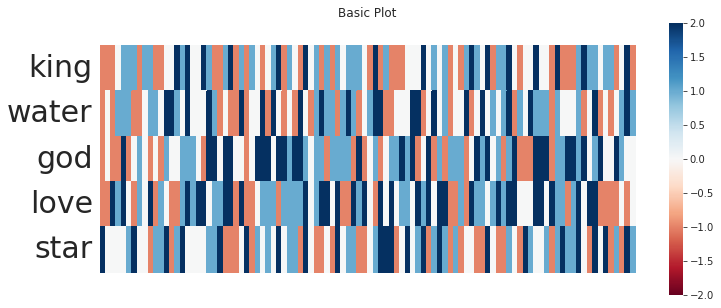

In [ ]:
kwargs = {'rot':0, 'pallete':'RdBu'}
EmbeddingPlot(vectors=np.random.randint(-1, 3, size=(5,100)), labels=['king', 'water', 'god', 'love', 'star'], **kwargs)

## ClusterPlot

In [ ]:
#export
class ClusterPlot(BasicVisual):
    def __init__(self, labels, embedding_clusters, word_clusters, **kwargs):
        self.labels = labels
        self.embedding_clusters = embedding_clusters
        self.word_clusters = word_clusters
        super(ClusterPlot, self).__init__(**kwargs)

    def plot(self):
        for label, embeddings, words in zip(self.labels, self.embedding_clusters, self.word_clusters):
            x = embeddings[:,0]
            y = embeddings[:,1]
            plt.scatter(x, y, label=label)
            for i, word in enumerate(words):
                plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                            textcoords='offset points', ha='right', va='bottom', size=8)
        plt.legend(loc=4)

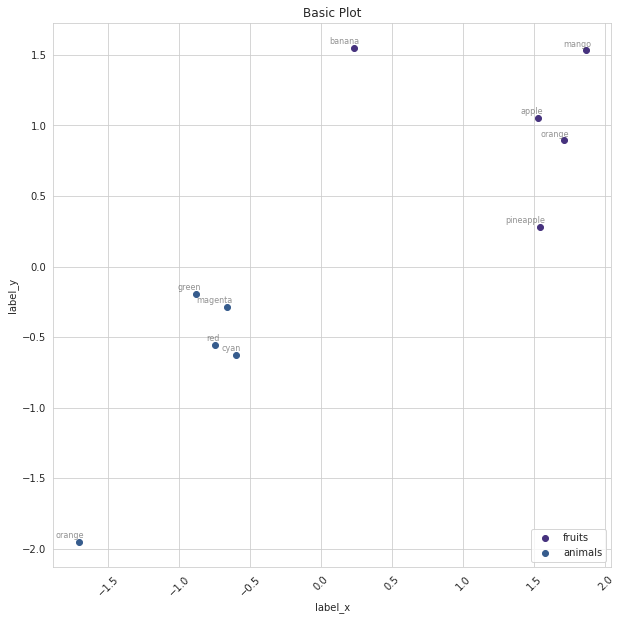

In [ ]:
embedding_clusters = np.vstack((np.random.random(size=(1,5,5))*2,
                                np.random.random(size=(1,5,5))*-2))
word_clusters = [['apple', 'banana', 'mango', 'pineapple', 'orange'], ['red', 'green', 'orange', 'magenta', 'cyan']]
labels = ['fruits', 'animals']

ClusterPlot(labels, embedding_clusters, word_clusters)

## TimelinePlot

In [ ]:
#export
class TimelinePlot(BasicVisual):
    def __init__(self, data, xticks_type='Month', xticks_interval=3, **kwargs):
        self.combined_data = data
        self.xticks_type = xticks_type
        self.xticks_interval = xticks_interval
        super(TimelinePlot, self).__init__(**kwargs)

    def plot(self):
        from datetime import datetime
        import matplotlib.dates as mdates
        import matplotlib.patches as mpatches

        # Group data by date
        if self.xticks_type=='Day':
            self.combined_data['date'] = self.combined_data['date'].dt.strftime('%Y-%m-%d')
            self.combined_data['date'] = self.combined_data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        else:
            self.combined_data['date'] = self.combined_data['date'].dt.strftime('%B %Y')
            self.combined_data['date'] = self.combined_data['date'].apply(lambda x: datetime.strptime(x, "%B %Y"))     
        
        self.combined_data = self.combined_data.groupby(['type', 'date', 'color']).size().rename('count').reset_index().sort_values('date')
        self.combined_data['name'] = self.combined_data['count'].map(str)+ ' '+self.combined_data['type']
        names = self.combined_data['name'].tolist()
        colors = self.combined_data['color'].tolist()
        dates = self.combined_data['date'].tolist()

        # Plot
        levels = np.array([-9, 9, -7, 7, -5, 5, -3, 3, -1, 1])

        # Create the base line
        start = min(dates)
        stop = max(dates)
        self.ax.plot((start, stop), (0, 0), 'k', alpha=.5)

        # Create annotations
        for ii, (iname, idate, icol) in enumerate(zip(names, dates, colors)):
            level = levels[ii % len(levels)]
            vert = 'top' if level < 0 else 'bottom'
            self.ax.scatter(idate, 0, s=100, facecolor=icol, edgecolor='k', zorder=9999)
            self.ax.plot((idate, idate), (0, level), c=icol, alpha=1.0, lw=2)
            self.ax.text(idate, level, iname, horizontalalignment='center', verticalalignment=vert, fontsize=12, backgroundcolor=icol)
        # Set the xticks formatting
        if self.xticks_type=='Month':
            self.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=self.xticks_interval))
            self.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%B %Y"))
        elif self.xticks_type=='Day':
            self.ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=self.xticks_interval))
            self.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        elif self.xticks_type=='Year':
            self.ax.get_xaxis().set_major_locator(mdates.YearLocator())
            self.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y"))        
        self.fig.autofmt_xdate()
        #Legend
        legend = []
        for index, row in self.combined_data[['type', 'color']].drop_duplicates().iterrows():
            legend += [mpatches.Patch(color=row['color'], label=row['type'])]
        plt.legend(handles=legend, loc='center left', bbox_to_anchor=(1, 0.5))
        
        # Remove components for a cleaner look
        plt.setp((self.ax.get_yticklabels() + self.ax.get_yticklines() + list(self.ax.spines.values())), visible=False)

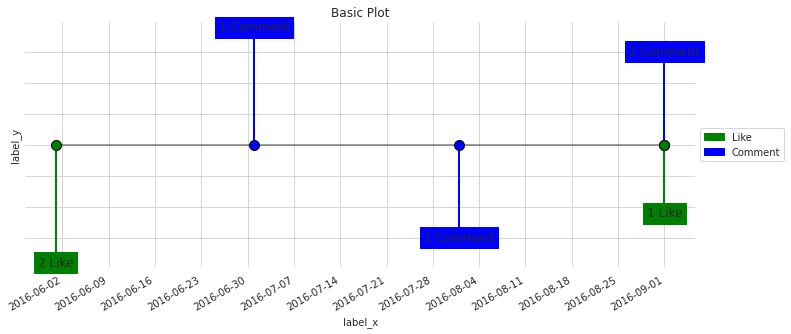

In [ ]:
# likes
likes_data = pd.DataFrame({'type':'Like', 
                        'date':['Jun 2016', 'Jun 2016', 'Sept 2016'],
                        'color':'green'})
likes_data['date'] = pd.to_datetime(likes_data['date'])

# professional registration
comments_data = pd.DataFrame({'type':'Comment', 
                        'date':['Jul 2016', 'Aug 2016', 'Sept 2016', 'Sept 2016'],
                        'color':'blue'})
comments_data['date'] = pd.to_datetime(comments_data['date'])

combined_data = pd.concat([likes_data, comments_data])

kwargs = {'figsize':(12,5)}

TimelinePlot(combined_data, xticks_type='Day', xticks_interval=7, **kwargs)

## ImageGridPlot

In [ ]:
#export
class ImageGridPlot(BasicVisual):
    def __init__(self, paths, labels, columns=5, **kwargs):
        self.paths = paths
        self.labels = labels
        self.columns = columns
        kwargs['figsize'] = (15,int(0.625 * len(paths)))
        # kwargs['nrows'] = len(paths) / columns + 1
        # kwargs['ncols'] = (15,int(0.625 * len(paths)))
        super(ImageGridPlot, self).__init__(**kwargs)

    def plot(self):
        from skimage import io

        for i, path in enumerate(self.paths):
            plt.subplot(len(self.paths) / self.columns + 1, self.columns, i + 1)
            image = io.imread(path)
            plt.imshow(image)
            plt.xticks(color = 'w', fontsize = 0.1)
            plt.yticks(color = 'w', fontsize = 0.1)
            plt.xlabel(self.labels[i], fontsize = 12)
            plt.tight_layout(h_pad=0.4, w_pad=0)
            plt.subplots_adjust(wspace=None, hspace=None)

In [ ]:
!wget -q --show-progress -O cat1.png "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT7nrOEKnuu0ek-bvr3MOq5JqL6-bm6-0-DyA&usqp=CAU"
!wget -q --show-progress -O cat2.png "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTvTSWBQeuHSGP2wLQTNsPOTHp0ok7CVQ2bGQ&usqp=CAU"

cat1.png            100%[===================>]   4.93K  --.-KB/s    in 0s      
cat2.png            100%[===================>]   5.87K  --.-KB/s    in 0s      


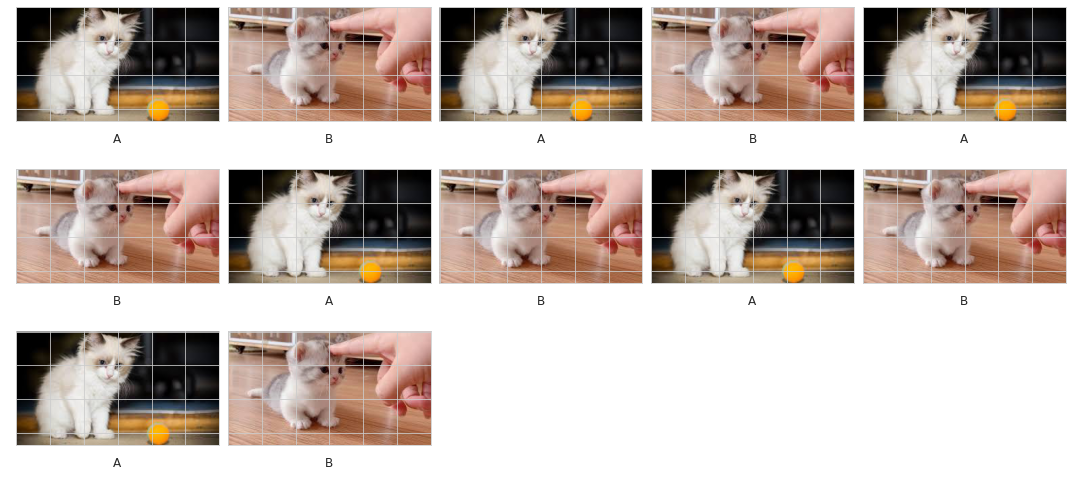

In [ ]:
df = pd.DataFrame.from_dict({
    'Path':['cat1.png', 'cat2.png'],
    'Label':['A','B']
})

df = df.append([df]*5,ignore_index=True)

ImageGridPlot(paths=df.Path.values,
              labels=df.Label.values)

## Wordcloud

In [ ]:
#export
def get_wordcloud(text_list):
    from wordcloud import WordCloud, STOPWORDS
    if isinstance(text_list, str):
        text_list = text_list.split(' ')

    stopwords = set(STOPWORDS).union([np.nan, 'NaN', 'S'])

    wordcloud = WordCloud(
                   max_words=50000,
                   min_font_size =12,
                   max_font_size=50,
                   relative_scaling = 0.9,
                   stopwords=set(STOPWORDS),
                   normalize_plurals= True
    )

    clean_titles = [word for word in text_list if word not in stopwords]
    title_wordcloud = wordcloud.generate(' '.join(clean_titles))

    plt.figure(figsize = (10,10))
    plt.imshow(title_wordcloud, interpolation='bilinear',)
    plt.axis("off")
    plt.show()

Example

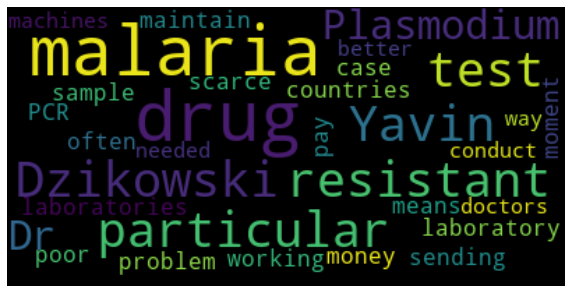

In [ ]:
text_str = """
At the moment, working out which drugs, if any, a particular case of malaria is 
resistant to means sending a sample to a laboratory for a PCR test. But malaria 
is most often a problem in poor countries, where such laboratories are scarce, 
and so is money to pay for tests and to maintain the machines needed to conduct 
them. A better way for doctors and paramedics in the field to be able to tell, 
for a particular patient, which drugs the infection is resistant to would thus 
be welcome. And that may soon be possible, thanks to work by Ron Dzikowski and 
Eylon Yavin of the Hebrew University in Jerusalem. As they write in ACS Sensors,
 they have come up with a trick which they think could be turned into a cheap 
 and deployable detector for drug resistance.
The term “malaria” covers several similar illnesses caused by single-celled 
parasites of the genus Plasmodium. The deadliest, Plasmodium falciparum, kills 
around 600,000 people a year, 80% of them children under five. Dr Dzikowski and 
Dr Yavin therefore focused their attention on this.
"""

get_wordcloud(text_str)

## AggregateTimePlot

In [ ]:
#export
class AggregateTimePlot(BasicVisual):
    def __init__(self, df, agg_col, ts_col, agg_method='count', ts_unit='s', **kwargs):
        self.df = df.copy()
        self.agg_col = agg_col
        self.ts_col = ts_col
        self.df[ts_col] = pd.to_datetime(self.df[ts_col], unit=ts_unit).dt.date
        self.df[agg_col] = self.df[agg_col].astype('str')
        self.df_group = self.df.groupby(ts_col).agg({agg_col: agg_method})
        super().__init__(**kwargs)

    def plot(self):
        sns.lineplot(data=self.df_group, x=self.ts_col, y=self.agg_col, ax=self.ax)

Example

In [ ]:
from recohut.utils.data import load_dataset

df = load_dataset('music30_sample')
df

,session_id,user_id,song_id,ts,playtime
0,1902204,4,16,1421163674,274
1,1902204,4,17,1421163948,250
2,1902204,4,18,1421164198,271
3,780919,10,60,1411009500,228
4,780919,10,61,1411014936,206
...,...,...,...,...,...
343178,282241,29371,922,1395982517,161
343179,282241,29371,6608,1395982678,254
343180,282241,29371,4893,1395983440,285
343181,282241,29371,2489,1395983725,218


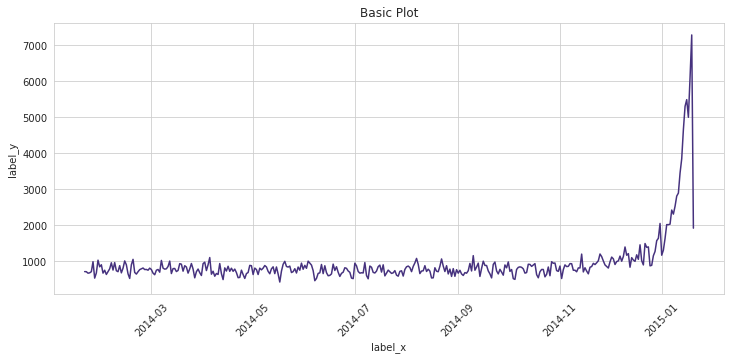

In [ ]:
kwargs = {'figsize':(12,5)}
g = AggregateTimePlot(df, agg_col='user_id', ts_col='ts', **kwargs)

## SparsePlot

In [ ]:
#export
class SparsePlot(BasicVisual):
    def __init__(self, df, sparse_col, target_col=None, agg_method='count', top_n=20, **kwargs):
        self.df = df.copy()
        self.sparse_col = sparse_col
        self.top_n = top_n
        self.agg_method = agg_method
        if target_col is None:
            target_col = '_target'
            self.df[target_col] = 1
        stats = self.df[[sparse_col, target_col]].groupby(sparse_col).agg(agg_method)
        stats = stats.reset_index()
        stats.columns = [sparse_col, agg_method]
        stats_sort = stats[agg_method].value_counts().reset_index()
        self.stats_sort = stats_sort.sort_values('index')
        super().__init__(**kwargs)

    def plot(self):
        plt.title('Frequency of ' + str(self.sparse_col))
        plt.xlabel('Number frequency')
        plt.ylabel('Frequency')
        self.ax = plt.bar(self.stats_sort['index'].astype(str).values[0:self.top_n], 
                          self.stats_sort[self.agg_method].values[0:self.top_n])

Example

In [ ]:
from recohut.utils.data import load_dataset

df = load_dataset('music30_sample')
df.head()

,session_id,user_id,song_id,ts,playtime
0,1902204,4,16,1421163674,274
1,1902204,4,17,1421163948,250
2,1902204,4,18,1421164198,271
3,780919,10,60,1411009500,228
4,780919,10,61,1411014936,206


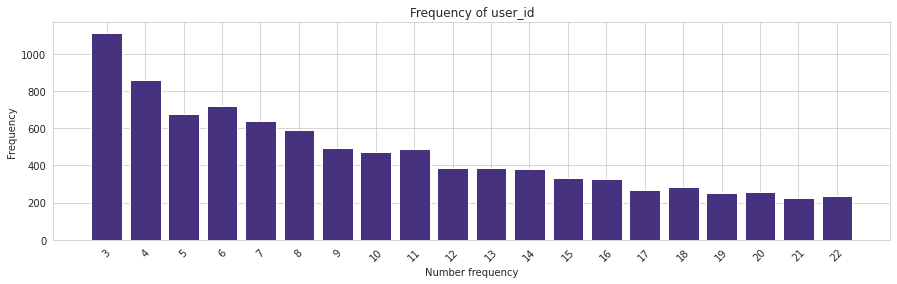

In [ ]:
kwargs = {'figsize':(15,4)}

f = SparsePlot(df, sparse_col='user_id', **kwargs)

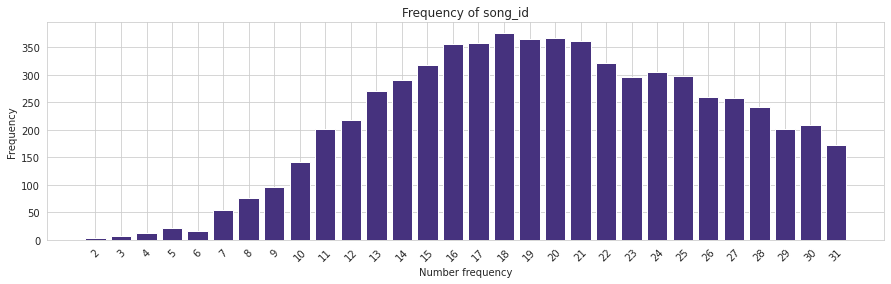

In [ ]:
kwargs = {'figsize':(15,4)}

f = SparsePlot(df, sparse_col='song_id', top_n=30, **kwargs)

## ItemPopularityPlot

In [ ]:
#export
class ItemPopularityPlot(BasicVisual):
    def __init__(self, item_counts, **kwargs):
        self.item_counts = item_counts
        super().__init__(**kwargs)

    def plot(self):
        self.ax = plt.semilogy(sorted(self.item_counts))

Example

In [ ]:
from recohut.utils.data import load_dataset

df = load_dataset('retail_session')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


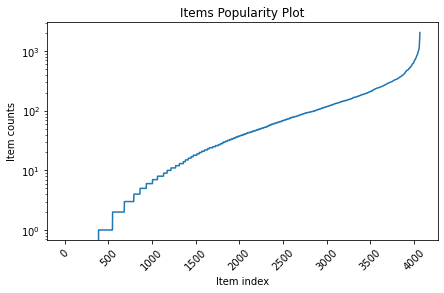

In [ ]:
kwargs = {'label_x':'Item index', 'label_y':'Item counts', 
            'figsize':(7,4), 'title':'Items Popularity Plot'}
item_counts = df.groupby(['StockCode']).count()['CustomerID'].values
_ = ItemPopularityPlot(item_counts, **kwargs)

## SessionLengthPlot

In [ ]:
#export
class SessionLengthPlot(BasicVisual):
    def __init__(self, session_lengths, **kwargs):
        self.session_lengths = session_lengths
        super().__init__(**kwargs)

    def plot(self):
        sns.boxplot(x=self.session_lengths, ax=self.ax)
        for patch in self.ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .7))

Example

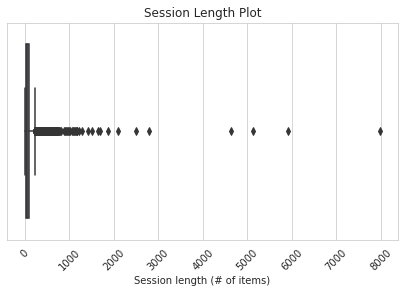

In [ ]:
kwargs = {'label_x':'Session length (# of items)', 'label_y':'', 
            'figsize':(7,4), 'title':'Session Length Plot'}
session_lengths = df.groupby('CustomerID').count()['StockCode'].values
_ = SessionLengthPlot(session_lengths, **kwargs)

## GraphNetworkPlot

In [ ]:
#export
class GraphNetworkPlot(BasicVisual):
    def __init__(self, data, color, node_size=140, **kwargs):
        self.data = data
        self.color = color
        self.node_size = node_size
        super().__init__(**kwargs)

    def plot(self):
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')
        if torch.is_tensor(self.data):
            h = self.data.detach().cpu().numpy()
            plt.scatter(self.data[:, 0], self.data[:, 1], s=self.node_size, 
                        c=self.color, cmap="Set2")
        else:
            nx.draw_networkx(self.data, pos=nx.spring_layout(self.data, seed=42), 
                                    with_labels=False, node_color=self.color, 
                                    cmap="Set2", ax=self.ax)

Example

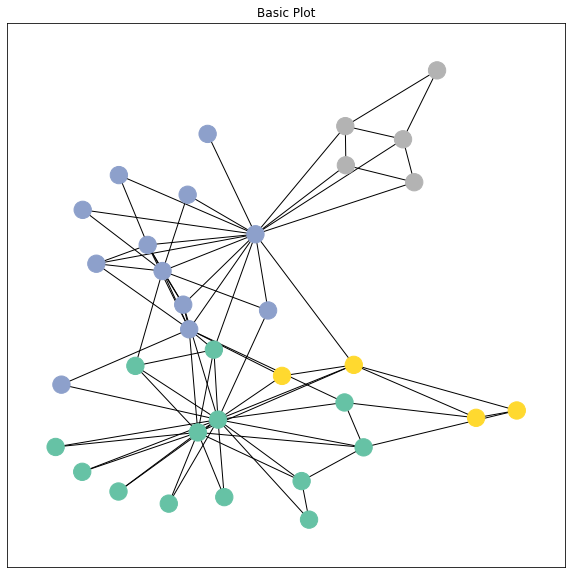

In [ ]:
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

dataset = KarateClub()

data = dataset[0]
G = to_networkx(data, to_undirected=True)
_ = GraphNetworkPlot(G, color=data.y)

In [ ]:
#hide
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p recohut

Author: Sparsh A.

Last updated: 2021-12-26 19:04:15

recohut: 0.0.7

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

skimage   : 0.18.3
pandas    : 1.1.5
IPython   : 5.5.0
seaborn   : 0.11.2
matplotlib: 3.2.2
numpy     : 1.19.5

